# Aula 3: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural simples para prever a proxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Língua".

Este dataset já possui um tamanho razoável e é bem provável que você vai precisar rodar seus experimentos com GPU.

Alguns conselhos úteis:
- **ATENÇÃO:** o dataset tem 2 milhões de tokens. Não dê comando de imprimí-lo
- durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- não deixe para fazer esse exercício na véspera. Ele é trabalhoso e precisará de um tempo maior que o exercício passado
- vamos compartilhando com os colegas sobre as dificuldades

# Download do dataset 

Iremos usar o dataset [Wikitext-2](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) para treinar e avaliar nosso modelo de linguagem.

In [ ]:
!wget -nc https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -o wikitext-2-v1.zip

File ‘wikitext-2-v1.zip’ already there; not retrieving.

Archive:  wikitext-2-v1.zip
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


## Importação dos pacotes

In [ ]:
import collections
import itertools
import random
import torch

import torch.nn as nn

import numpy as np
from tqdm import tqdm_notebook
from math import floor
from math import ceil
from matplotlib import pyplot as plt

if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))


Using cuda:0


In [ ]:
device.type

'cuda'

## Leitura e preparação do dataset

In [ ]:
def load_tokens(path):
    text = open(path).read().lower()
    # Split sem argumentos remove quebras de linha e espaços duplicados.
    return text.split()
    

def build_vocab(tokens, vocab_size):
    word_frequency = collections.Counter(tokens)

    vocab = {token: index for index, (token, _) in enumerate(
        word_frequency.most_common(vocab_size))}

    # Adicionamos o token "<unk>" para lidar com palavras não presentes no
    # vocabulário . O dataset text8 já contem este token, mas pode ser que ele
    # não tenha sido adicionado quando filtramos com `vocab_size`.
    if '<unk>' not in vocab:
        vocab['<unk>'] = len(vocab)
    if '[PAD]' not in vocab:
        vocab['[PAD]'] = len(vocab)
    return vocab 


In [ ]:
train_tokens = load_tokens('wikitext-2/wiki.train.tokens')
valid_tokens = load_tokens('wikitext-2/wiki.valid.tokens')
test_tokens = load_tokens('wikitext-2/wiki.test.tokens')

In [ ]:
len(train_tokens), len(valid_tokens), len(test_tokens)

(2051910, 213886, 241211)

In [ ]:
print(train_tokens[100:115])

[',', 'a', 'penal', 'military', 'unit', 'serving', 'the', 'nation', 'of', 'gallia', 'during', 'the', 'second', 'europan', 'war']


In [ ]:
train_tokens = train_tokens[:10000]
valid_tokens = valid_tokens[:10000]
test_tokens = test_tokens[:10000]

In [ ]:
vocab_size = 1000
vocab = build_vocab(train_tokens, vocab_size=vocab_size)
print(f'Vocab has {len(vocab)} tokens')
print(f'10 sample tokens: {list(itertools.islice(vocab.keys(), 10))}')
vocab_size = (len(vocab))

Vocab has 1001 tokens
10 sample tokens: ['the', ',', '.', 'of', '<unk>', 'and', 'in', 'to', 'a', '=']


In [ ]:
padding = '[PAD]'
n_padding = 3
tst = [padding for pad in range(n_padding)]
tst0 = ['Esse', 'e', 'um', 'tst']
tst2 = tst + tst0
tst2

['[PAD]', '[PAD]', '[PAD]', 'Esse', 'e', 'um', 'tst']

## Embedding por One Hot Encoding

In [ ]:
def gen_n_gram(corpus, vocab, context_size = 5):
  padding = '[PAD]'
  unk = '<unk>'
  list_padding = [padding for pad in range(context_size)]
  corpus = list_padding + corpus
  X = []
  Y = []
  for index, token in enumerate(corpus):
    sentence = []
    if index+context_size<len(corpus):
      y_index = index+context_size
      
      for inc in range(context_size):
        if corpus[index+inc] in vocab.keys():
          sentence.append(vocab[corpus[index+inc]])
        else:
          sentence.append(vocab[unk])
      
      X.append(sentence)

      if corpus[y_index] in vocab.keys():
        Y.append(vocab[corpus[y_index]])
      else:
        Y.append(vocab[unk])

  return torch.tensor(X, dtype = torch.long), torch.tensor(Y, dtype = torch.long)


In [ ]:
def one_hot_encoding(sentences, vocab_size):
  
  if sentences.ndim==1:
    context_size = len(sentences)
    list_indexes = range(context_size)
    sentences_OHE = torch.zeros((context_size,vocab_size), dtype= torch.float)
    sentences_OHE[list_indexes,sentences] = 1.0
  else:
    batch_size = sentences.shape[0]
    context_size = sentences.shape[1]
    list_index = range(context_size)
    sentences_OHE = torch.zeros((batch_size,context_size,vocab_size), dtype = torch.float)
    for index, sentence in enumerate(sentences):
      sentences_OHE[index,list_index,sentence] = 1
        

  
  return sentences_OHE

In [ ]:
X_train, Y_train = gen_n_gram(train_tokens,vocab)
X_test, Y_test = gen_n_gram(test_tokens,vocab)
X_val, Y_val = gen_n_gram(valid_tokens,vocab)

### Criação dos modelos:
Primeiro modelo possui uma camada inicial utilizando one-hot-encoding para o embedding das palavras. Uma camada intermediária onde concatena-se os vetores do context (context_size = 5) na entrada, passa-se por uma tangente hiperbólica e por mais uma camada com entrada=5*tamanho do embedding e saída=1000 (hidden_size). Há uma ReLU e por fim a camada de saída que produz os logitos com tamanho igual ao tamanho do vocabulário.

O segundo modelo diferencia-se apenas pela substituição do one-hot-encoding pelo embedding do pytorch.

In [ ]:
class ModelOneHotEnconding(torch.nn.Module):
  def __init__(self,vocab_size,embedding_dim,hidden_size = 1000, context_size = 5):
    super().__init__()
    self.vocab_size = vocab_size
    self.context_size = context_size
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size
    self.layer0 = one_hot_encoding
    self.layer1 = torch.nn.Linear(vocab_size, embedding_dim)
    self.layer_tanh = torch.nn.Tanh()
    self.layer2 = torch.nn.Linear(embedding_dim*context_size, hidden_size)
    self.layer_relu = torch.nn.ReLU()
    self.layer3 = torch.nn.Linear(hidden_size, vocab_size)
  
  def forward(self,x):
    x = self.layer0(x.to('cpu'),self.vocab_size).to(device)
    x = self.layer1(x)
    x = x.reshape(-1,self.embedding_dim*self.context_size)
    x = self.layer_tanh(x)
    x = self.layer2(x)
    x = self.layer_relu(x)
    x = self.layer3(x)
    if self.training:
      x[:,vocab['<unk>']] = 0

    return x

class ModelEmbedding(torch.nn.Module):
  def __init__(self,vocab_size,embedding_dim,hidden_size = 1000, context_size = 5):
    super().__init__()
    self.vocab_size = vocab_size
    self.context_size = context_size
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size
    self.layer1 = torch.nn.Embedding(vocab_size,embedding_dim)
    self.layer_tanh = torch.nn.Tanh()
    self.layer2 = torch.nn.Linear(embedding_dim*context_size, hidden_size)
    self.layer_relu = torch.nn.ReLU()
    self.layer3 = torch.nn.Linear(hidden_size, vocab_size)
  
  def forward(self,x):
    x = self.layer1(x)
    x = x.reshape(-1,self.embedding_dim*self.context_size)
    x = self.layer_tanh(x)
    x = self.layer2(x)
    x = self.layer_relu(x)
    x = self.layer3(x)
    if self.training:
      x[:,vocab['<unk>']] = 0

    return x

In [ ]:
model = ModelOneHotEnconding(10000,32)
[x.size() for x in model.parameters()]

[torch.Size([32, 10000]),
 torch.Size([32]),
 torch.Size([1000, 160]),
 torch.Size([1000]),
 torch.Size([10000, 1000]),
 torch.Size([10000])]

In [ ]:
model = ModelEmbedding(10000,32)
[x.size() for x in model.parameters()]

[torch.Size([10000, 32]),
 torch.Size([1000, 160]),
 torch.Size([1000]),
 torch.Size([10000, 1000]),
 torch.Size([10000])]

In [ ]:
def create_batch(X,Y,batch_size):
  mini_batches_X = []
  mini_batches_Y = []
  n_batches = ceil(X.shape[0]/batch_size)
  start = 0
  end = batch_size
  for n in range(n_batches):
    mini_batches_X.append(X[start:end,:])
    mini_batches_Y.append(Y[start:end])
    start += batch_size
    end += batch_size if start+batch_size<X.shape[0]+1 else X.shape[0] % batch_size
  return mini_batches_X, mini_batches_Y
    

In [ ]:
def test(X, Y, model,batch_size, loss_function):
  batches_X, batches_Y = create_batch(X,Y,batch_size)
  running_loss = 0
  model.eval()
  with torch.no_grad():
    for index, batch in enumerate(batches_X):
      batch = batch.to(device)
      y_logits = model(batch)
      loss = loss_function(y_logits,batches_Y[index].to(device))
      running_loss += loss.item()
      # print("Running Loss Test: {}".format(running_loss))
    test_loss = running_loss/len(batches_X)
    ppl = calc_ppl(loss)
    print("Loss: {:.4f} Perplexity: {:.4f}".format(test_loss, ppl))
  return test_loss, ppl
def calc_ppl(loss):
  if type(loss) is list:
    mean = np.mean(loss)
  else:
    mean = loss
  if device.type == "cuda":
    ppl = np.exp(mean.cpu().numpy())
  else:
    ppl = np.exp(mean)
  return ppl

def train(X, Y, batch_size, model, n_epochs, optimizer, loss_function = torch.nn.CrossEntropyLoss(), validate = False, X_val = None, Y_val = None):
  train_loss_list = []
  test_loss_list = []
  ppl_list = []
  progress = tqdm_notebook(total=n_epochs)
  print(next(model.parameters()).is_cuda)
  model = model.to(device)
  print(next(model.parameters()).is_cuda)
  for epoch in range(n_epochs):
    # print(epoch)
    model.train()
    running_loss= 0.0
    batches_X, batches_Y = create_batch(X,Y,batch_size)
    for index, batch in enumerate(batches_X):
      batch = batch.to(device)
      y_logits = model(batch)
      loss = loss_function(y_logits,batches_Y[index].to(device))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      running_loss += loss.item()
    
    train_loss_list.append(running_loss/len(batches_X))
    if validate:
      if X_val is None or Y_val is None:
        print("Validation Error: Empty validation data") 
      else:
        test_loss, ppl = test(X_val, Y_val,model,1000, loss_function)
        test_loss_list.append(test_loss)
        ppl_list.append(ppl)
      # y_logits = mode

    
    if validate:
      plt.plot(ppl_list)
      plt.title("Perplexity x Epochs")
    progress.update(1)
  return train_loss_list

In [ ]:
batch_size = 200
Model_OneHot = ModelOneHotEnconding(len(vocab),32)
Model_OneHot.to(device)
opt = torch.optim.SGD(Model_OneHot.parameters(), lr = 0.01)

train_points = train(X_train,Y_train, batch_size, Model_OneHot, 5, opt, validate= False, X_val = X_val, Y_val=Y_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


True
True


In [ ]:
def test(X, Y, model,batch_size, loss_function):
  batches_X, batches_Y = create_batch(X,Y,batch_size)
  running_loss = 0
  model.eval()
  with torch.no_grad():
    for index, batch in enumerate(batches_X):
      batch = batch.to(device)
      y_logits = model(batch)
      loss = loss_function(y_logits,batches_Y[index].to(device))
      running_loss += loss.item()
      # print("Running Loss Test: {}".format(running_loss))
    test_loss = running_loss/len(batches_X)
    ppl = calc_ppl(loss)
    print("Loss: {:.4f} Perplexity: {:.4f}".format(test_loss, ppl))
  return test_loss, ppl
def calc_ppl(loss):
  if type(loss) is list:
    mean = np.mean(loss)
  else:
    mean = loss
  if device.type == "cuda":
    ppl = np.exp(mean.cpu().numpy())
  else:
    ppl = np.exp(mean)
  return ppl

## Teste das funções

### Criar n_grams a partir do dataset

In [ ]:
X_train, Y_train = gen_n_gram(train_tokens,vocab)
X_test, Y_test = gen_n_gram(test_tokens,vocab)
X_val, Y_val = gen_n_gram(valid_tokens,vocab)

In [ ]:
X_train.shape, Y_train.shape

(torch.Size([10000, 5]), torch.Size([10000]))

In [ ]:
print(X_train)

tensor([[1000, 1000, 1000, 1000, 1000],
        [1000, 1000, 1000, 1000,    9],
        [1000, 1000, 1000,    9,   21],
        ...,
        [   2,  105,    0,  394,    3],
        [ 105,    0,  394,    3,   26],
        [   0,  394,    3,   26,   94]])


### One Hot Encoding

In [ ]:
print(vocab_size)
X_train_OHE = one_hot_encoding(X_train,vocab_size)


1001


In [ ]:
X_train_OHE.shape, X_train_OHE[0,0,:].sum()

(torch.Size([10000, 5, 1001]), tensor(1.))

Dimensões corretas: 100000 amostras, cada com 5 palavras de contexto e cada palavra representada por um vetor de 1001 posições com zero em todos elementos, exceto na posição da respectiva palavra.

## Modelo utilizando One Hot Encoding

In [ ]:
batch_size = 200
embedding_dim = 32
Model_OneHot = ModelOneHotEnconding(vocab_size,embedding_dim)

In [ ]:
y_logit_tst = Model_OneHot(X_train[0].to(device))
y_logit_tst

tensor([[ 4.4228,  4.2153,  3.8576,  ..., -0.7638, -0.6259, -0.7242]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
y_logit_tst.shape

torch.Size([1, 1001])

Shape correto: 1 sample com número de colunas = vocab_size

### Treino com validação

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


False
True
Loss: 6.9042 Perplexity: 995.3470
Loss: 6.8901 Perplexity: 980.1833
Loss: 6.8755 Perplexity: 964.8090
Loss: 6.8603 Perplexity: 949.0071
Loss: 6.8442 Perplexity: 932.5134
Loss: 6.8268 Perplexity: 915.0269
Loss: 6.8077 Perplexity: 896.1968
Loss: 6.7862 Perplexity: 875.5062
Loss: 6.7615 Perplexity: 852.2350
Loss: 6.7322 Perplexity: 825.3574
Loss: 6.6960 Perplexity: 793.3767
Loss: 6.6497 Perplexity: 754.2723
Loss: 6.5884 Perplexity: 705.2903
Loss: 6.5050 Perplexity: 643.6874
Loss: 6.3947 Perplexity: 570.1683
Loss: 6.2700 Perplexity: 496.7403
Loss: 6.1717 Perplexity: 445.5445
Loss: 6.1073 Perplexity: 416.5165
Loss: 6.0584 Perplexity: 397.9346
Loss: 6.0211 Perplexity: 385.6425
Loss: 5.9934 Perplexity: 377.6123
Loss: 5.9725 Perplexity: 372.0995
Loss: 5.9560 Perplexity: 367.8960
Loss: 5.9424 Perplexity: 364.4130
Loss: 5.9309 Perplexity: 361.4275
Loss: 5.9211 Perplexity: 358.8697
Loss: 5.9128 Perplexity: 356.7030
Loss: 5.9057 Perplexity: 354.8889
Loss: 5.8995 Perplexity: 353.3770
Los

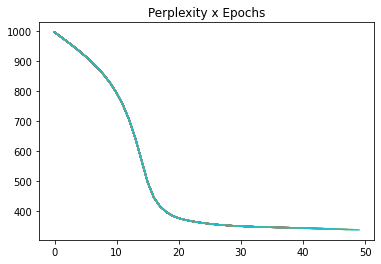

In [ ]:
batch_size = 200
n_epochs = 50
opt = torch.optim.SGD(Model_OneHot.parameters(), lr = 0.01)
train_points = train(X_train,Y_train, batch_size, Model_OneHot,n_epochs, opt, validate= True, X_val = X_val, Y_val=Y_val)

[6.9046620178222655, 6.890345573425293, 6.875811786651611, 6.860850477218628, 6.845216932296753, 6.8286100769042966, 6.810649452209472, 6.790825119018555, 6.768382377624512, 6.742228670120239, 6.710714530944824, 6.671290731430053, 6.620072708129883, 6.551294784545899, 6.458380966186524, 6.342275066375732, 6.229135503768921, 6.14901330947876, 6.092774238586426, 6.049008865356445, 6.0150540256500244, 5.988696279525757, 5.967370796203613, 5.949229316711426, 5.933313236236573, 5.919192218780518, 5.906644229888916, 5.895500078201294, 5.885595006942749, 5.876767597198486, 5.868872957229614, 5.861788644790649, 5.855411281585694, 5.849653596878052, 5.844439859390259, 5.839702453613281, 5.835380868911743, 5.831422271728516, 5.827780122756958, 5.824412059783936, 5.821281671524048, 5.818357877731323, 5.81561240196228, 5.813023052215576, 5.8105695438385006, 5.808234605789185, 5.806002950668335, 5.803862533569336, 5.801802110671997, 5.799812450408935]


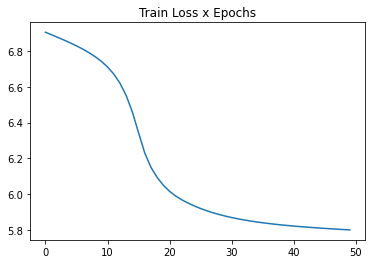

In [ ]:
plt.plot(train_points)
plt.title("Train Loss x Epochs")
print(train_points)

# plt.xlim((0,40))

## Modelo utilizando Embedding

In [ ]:
embedding_dim = 32
Model_Embedding = ModelEmbedding(vocab_size,embedding_dim)
Model_Embedding.to(device)

ModelEmbedding(
  (layer1): Embedding(1001, 32)
  (layer_tanh): Tanh()
  (layer2): Linear(in_features=160, out_features=1000, bias=True)
  (layer_relu): ReLU()
  (layer3): Linear(in_features=1000, out_features=1001, bias=True)
)

In [ ]:
y_logit_tst = Model_Embedding(X_train[0].to(device))
y_logit_tst

tensor([[ 0.0361,  0.0037,  0.0978,  ..., -0.1026, -0.0612, -0.2185]],
       device='cuda:0', grad_fn=<CopySlices>)

In [ ]:
y_logit_tst.shape

torch.Size([1, 1001])

Shape correto: 1 sample com número de colunas = vocab_size

### Treino com validação

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


True
True
Loss: 6.7710 Perplexity: 861.2027
Loss: 6.6226 Perplexity: 732.0959
Loss: 6.4829 Perplexity: 627.8809
Loss: 6.3603 Perplexity: 548.2455
Loss: 6.2626 Perplexity: 491.8515
Loss: 6.1893 Perplexity: 453.6445
Loss: 6.1342 Perplexity: 427.5540
Loss: 6.0918 Perplexity: 409.3323
Loss: 6.0586 Perplexity: 396.3214
Loss: 6.0321 Perplexity: 386.8339
Loss: 6.0109 Perplexity: 379.7618
Loss: 5.9935 Perplexity: 374.3326
Loss: 5.9791 Perplexity: 370.0061
Loss: 5.9667 Perplexity: 366.4140
Loss: 5.9559 Perplexity: 363.3190
Loss: 5.9462 Perplexity: 360.5735
Loss: 5.9376 Perplexity: 358.0878
Loss: 5.9297 Perplexity: 355.8122
Loss: 5.9224 Perplexity: 353.7139
Loss: 5.9158 Perplexity: 351.7708
Loss: 5.9096 Perplexity: 349.9691
Loss: 5.9039 Perplexity: 348.2950
Loss: 5.8986 Perplexity: 346.7368
Loss: 5.8936 Perplexity: 345.2877
Loss: 5.8890 Perplexity: 343.9370
Loss: 5.8846 Perplexity: 342.6724
Loss: 5.8805 Perplexity: 341.4867
Loss: 5.8765 Perplexity: 340.3733
Loss: 5.8728 Perplexity: 339.3259
Loss

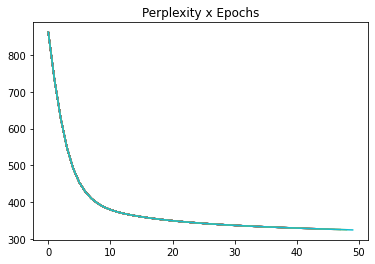

In [ ]:
batch_size = 200
n_epochs = 50
opt = torch.optim.SGD(Model_Embedding.parameters(), lr = 0.01)
train_points = train(X_train,Y_train, batch_size, Model_Embedding, n_epochs, opt, validate= True, X_val = X_val, Y_val=Y_val)

[6.84082200050354, 6.689137992858886, 6.54443021774292, 6.412711963653565, 6.301737966537476, 6.2146259117126466, 6.14734977722168, 6.0941361141204835, 6.050859031677246, 6.014897327423096, 5.984500970840454, 5.958370733261108, 5.9354868984222415, 5.915069789886474, 5.896549558639526, 5.879519090652466, 5.863691120147705, 5.848861646652222, 5.834883489608765, 5.821645345687866, 5.80906156539917, 5.797060747146606, 5.785582571029663, 5.774576053619385, 5.763997001647949, 5.753806238174438, 5.743970708847046, 5.734458818435669, 5.72524398803711, 5.716303415298462, 5.707615833282471, 5.69916184425354, 5.690924205780029, 5.682888040542602, 5.6750390911102295, 5.667364683151245, 5.659853382110596, 5.6524951457977295, 5.645280294418335, 5.638199977874756, 5.631245336532593, 5.6244085502624515, 5.6176835060119625, 5.61106388092041, 5.604542808532715, 5.598114624023437, 5.591774530410767, 5.585517578125, 5.579339818954468, 5.573236885070801]


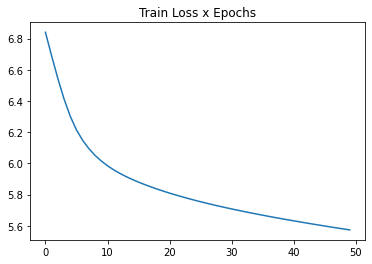

In [ ]:
plt.plot(train_points)
plt.title("Train Loss x Epochs")
print(train_points)

É possível perceber o melhor desempenho no modelo utilizando torch.Embedding em relação ao One Hot Encoding, tanto no custo quanto na perplexidade.

## Testando em todo Dataset:

In [ ]:
train_tokens = load_tokens('wikitext-2/wiki.train.tokens')
valid_tokens = load_tokens('wikitext-2/wiki.valid.tokens')
test_tokens = load_tokens('wikitext-2/wiki.test.tokens')

In [ ]:
vocab_size = 10000
vocab = build_vocab(train_tokens, vocab_size=vocab_size)
print(f'Vocab has {len(vocab)} tokens')
print(f'10 sample tokens: {list(itertools.islice(vocab.keys(), 10))}')
vocab_size = (len(vocab))

Vocab has 10001 tokens
10 sample tokens: ['the', ',', '.', 'of', '<unk>', 'and', 'in', 'to', 'a', '=']


In [ ]:
X_train, Y_train = gen_n_gram(train_tokens,vocab)
X_test, Y_test = gen_n_gram(test_tokens,vocab)
X_val, Y_val = gen_n_gram(valid_tokens,vocab)

In [ ]:
embedding_dim = 32
Model_Embedding = ModelEmbedding(vocab_size,embedding_dim)
Model_Embedding.to(device)

ModelEmbedding(
  (layer1): Embedding(10001, 32)
  (layer_tanh): Tanh()
  (layer2): Linear(in_features=160, out_features=1000, bias=True)
  (layer_relu): ReLU()
  (layer3): Linear(in_features=1000, out_features=10001, bias=True)
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


True
True
Loss: 7.2707 Perplexity: 1528.0236
Loss: 7.0730 Perplexity: 1221.1324
Loss: 6.9716 Perplexity: 1044.6313
Loss: 6.9043 Perplexity: 943.2239
Loss: 6.8535 Perplexity: 880.1348
Loss: 6.8131 Perplexity: 836.0829
Loss: 6.7798 Perplexity: 802.3254
Loss: 6.7514 Perplexity: 774.7576
Loss: 6.7266 Perplexity: 751.3929
Loss: 6.7046 Perplexity: 731.1738
Loss: 6.6847 Perplexity: 713.4271
Loss: 6.6667 Perplexity: 697.7039
Loss: 6.6500 Perplexity: 683.6240
Loss: 6.6346 Perplexity: 670.8403
Loss: 6.6202 Perplexity: 659.1072
Loss: 6.6066 Perplexity: 648.2164
Loss: 6.5937 Perplexity: 638.0073
Loss: 6.5814 Perplexity: 628.3616
Loss: 6.5696 Perplexity: 619.1837
Loss: 6.5583 Perplexity: 610.4146
Loss: 6.5474 Perplexity: 601.9952
Loss: 6.5369 Perplexity: 593.8885
Loss: 6.5266 Perplexity: 586.0622
Loss: 6.5166 Perplexity: 578.4902
Loss: 6.5069 Perplexity: 571.1318
Loss: 6.4973 Perplexity: 563.9826
Loss: 6.4880 Perplexity: 557.0336
Loss: 6.4788 Perplexity: 550.2666
Loss: 6.4697 Perplexity: 543.6797
L

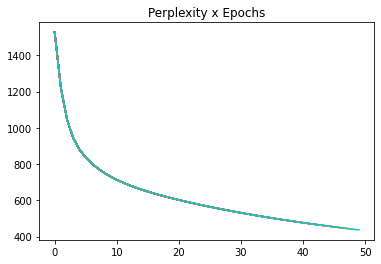

In [ ]:
batch_size = 1000
n_epochs = 50
opt = torch.optim.SGD(Model_Embedding.parameters(), lr = 0.01)
train_points = train(X_train,Y_train, batch_size, Model_Embedding, n_epochs, opt, validate= True, X_val = X_val, Y_val=Y_val)

[7.7535745247065675, 7.132948342587283, 6.988326309949566, 6.9029552255689985, 6.8436591622889855, 6.798076503225702, 6.76118514179951, 6.730179691640025, 6.703325724508795, 6.6795502982409145, 6.658155108520627, 6.638661182182342, 6.620710456348069, 6.604020540012486, 6.588363403697692, 6.573552046138176, 6.559445950720045, 6.545937059915554, 6.532940363093891, 6.52038772482621, 6.508223624489693, 6.496400432279932, 6.4848746447070535, 6.473608007905079, 6.462566978517796, 6.45172436799687, 6.441056096065811, 6.430543737104761, 6.420171116295381, 6.40992507437284, 6.3997951804081135, 6.389771272796869, 6.379844727804321, 6.370008652205588, 6.360256083295127, 6.350580828464055, 6.3409757384082726, 6.331435002778706, 6.321951626569439, 6.312519292617634, 6.303131099332843, 6.293780413055048, 6.284458433210734, 6.27515747463494, 6.265870269511411, 6.256587376836215, 6.2473002909219755, 6.237998680529306, 6.228673204111542, 6.2193125072743225]


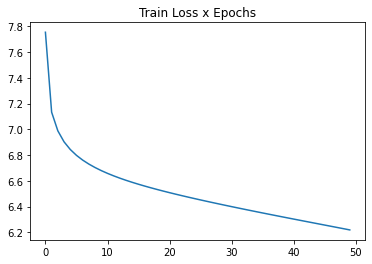

In [ ]:
plt.plot(train_points)
plt.title("Train Loss x Epochs")
print(train_points)

## Test set

In [ ]:
Model_Embedding.eval()
loss_testset, ppl_testset = test(X_test.to(device),Y_test.to(device),Model_Embedding,batch_size,torch.nn.CrossEntropyLoss())
print("Perplexity in Test Set: {}".format(ppl_testset))

Loss: 6.2934 Perplexity: 344.8030
Perplexity in Test Set: 344.8030090332031


In [ ]:
dict_ohe2word = {value : word for (word,value) in vocab.items()}
def predict(X, model):
  model.eval()
  softmax = nn.Softmax(dim=1)
  with torch.no_grad():
    y_logits = model(X.to(device))
    y_prob = softmax(y_logits)
    y_pred = y_prob.argmax()
  return y_pred

  return
def vector2word(index):
  return dict_one2word[index]


In [ ]:
x = predict(X_test[100],Model_Embedding)
x = x.cpu().numpy()
x.item()
dict_ohe2word[x.item()]

'the'

## Exemplos de predição usando o modelo


In [ ]:
for i in range(5):
  print(i)
  print('\n')
  sample = np.random.randint(0,X_test.shape[0])
  sentence = [dict_ohe2word[token.item()] for token in X_test[sample]]
  # print(sentence)
  sentence_true = sentence + [dict_ohe2word[Y_test[sample].item()]]
  sentence_true  = ' '.join(sentence_true)
  token_predict = predict(X_test[sample],Model_Embedding).item()
  sentence_pred = sentence + [dict_ohe2word[token_predict]]
  sentence_pred = ' '.join(sentence_pred)
  print("True:      {}\nPredicted: {}\n\n".format(sentence_true, sentence_pred))


0


True:      ) on the 9 september 1939
Predicted: ) on the 9 september of


1


True:      <unk> with her , which are
Predicted: <unk> with her , which was


2


True:      = originally , <unk> were classified
Predicted: = originally , <unk> were ,


3


True:      greek and jewish religious tension .
Predicted: greek and jewish religious tension of


4


True:      and in may blocked traffic by
Predicted: and in may blocked traffic ,




É possível perceber que o modelo tende a predizer preposições e pontuações. Apesar disso, as sentenças criadas tem um fundo semântico que pode ser considerado válido.